In [1]:

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import fnmatch
from scipy import interpolate 
from scipy import signal
import seaborn as sns


In [6]:
import sys
sys.path.insert(0, 'C:/src/Github/FreelyMovingEphys')

In [7]:
from util.config import set_preprocessing_config_defaults, str_to_bool, open_config

In [2]:

def find(pattern, path):
    """
    glob for subdirectories
    INPUTS:
        pattern -- str (with * for missing sectiosn of characters) like glob function
        path -- dict to search, including subdirectories
    OUTPUTS:
        result -- list of files
    """
    result = [] # initialize the list as empty
    for root, dirs, files in os.walk(path): # walk though the path directory, and files
        for name in files:  # walk to the file in the directory
            if fnmatch.fnmatch(name,pattern):  # if the file matches the filetype append to list
                result.append(os.path.join(root,name))
    return result # return full list of file of a given type

work on smoothing the TTL - still need to figure out how to line up with camera data

In [57]:
file='T:/OptoPreyCapture/050721/PVCH13p3RT/trial_3/050721_PVCH13p3RT_laser_on_Rig2_trial_3_imu.nc'

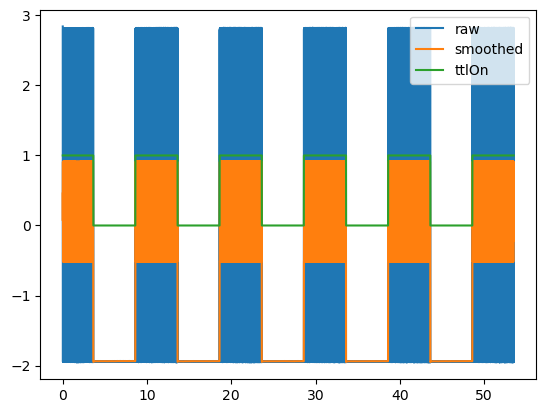

In [86]:
plt.close('all')
# load data
imu_file = file
imu_data = xr.open_dataset(imu_file)
acc_chans = imu_data.IMU_data
ttl = np.array(acc_chans.sel(channel='acc_x'))
ttlT = np.asarray(imu_data.timestamps-timestamps[0])
# smooth and threshold
win = 10;
ttlSmooth = np.convolve(ttl,np.ones(win)/win,'same')
ttlOn = ttlSmooth>-1;
plt.plot(ttlT-ttlT[0],ttl, label = 'raw')
plt.plot(ttlT-ttlT[0],ttlSmooth, label = 'smoothed')
plt.plot(ttlT-ttlT[0],ttlOn, label = 'ttlOn')
plt.legend()
plt.show()
# interplolate
topT=t
ttlInterp = interpolate.interp1d(ttlT,ttlOn,'nearest', bounds_error = False)
ttlTop = ttlInterp(topT)  ### topT should be whatever you variable is for the timestamps of topdown camera

### Define function to calculate probabilities, time to capture, and frequency of approach. Can also create rough trajectory, speed, range and azimuth plots for data visualization

In [132]:
def calculations(f, plotter = False):
    '''
    function to do calculations on mouse and cricket DLC data
    
    INPUTS
        f : string
            filename of data file
        plotter : boolean
            whether or not to plot data
            
    RETURNS
        capturet : int
            time mouse captures cricket
        timetoapproach: int
            latency to first approach 
        freqapproach: int
            frequency mouse approaches cricket, fraction of total time
        prob_inter: int
            probability mouse intercepts cricket given approach
        prob_capture: int
            probability of capture given interception
    '''
    pixpercm = 14.5
    thresh = 0.99
    framerate = 60
    # load all of data in file
    data = xr.open_dataset(f)

    # load DLC points for mouse
    Cricket_p = data['TOP1_pts'].sel(point_loc='Cricket1_likelihood').data
    Rear_x = data['TOP1_pts'].sel(point_loc='Rear_x').data/pixpercm
    Rear_y = data['TOP1_pts'].sel(point_loc='Rear_y').data/pixpercm
    Rear_xy=np.asarray([Rear_x, Rear_y])
    Lear_x = data['TOP1_pts'].sel(point_loc='Lear_x').data/pixpercm
    Lear_y = data['TOP1_pts'].sel(point_loc='Lear_y').data/pixpercm
    Lear_xy=np.asarray([Lear_x, Lear_y])
    mouse_xy=0.5*(Rear_xy+Lear_xy)
    
    # load DLC points for cricket
    Cricket_x = (data['TOP1_pts'].sel(point_loc='Cricket1_x').data+data['TOP1_pts'].sel(point_loc='Cricket2_x').data)/2
    Cricket_y = (data['TOP1_pts'].sel(point_loc='Cricket1_y').data+data['TOP1_pts'].sel(point_loc='Cricket2_y').data)/2
    Cricket_x=Cricket_x/pixpercm
    Cricket_y=Cricket_y/pixpercm
    crick_x_thresh = Cricket_x.copy()
    crick_x_thresh[Cricket_p < thresh] = np.nan
    crick_y_thresh = Cricket_y.copy()
    crick_y_thresh[Cricket_p < thresh] = np.nan
    Cricket_xy=[crick_x_thresh, crick_y_thresh]
    
#     plt.figure()
#     plt.plot(crick_x_thresh,'.')
#     plt.plot(crick_y_thresh,'.')
#     plt.xlabel('cricket threshold position')  

    #interpolate values to fill NaNs
    ind = np.arange(0,len(crick_x_thresh))
    interp = interpolate.interp1d(ind[~np.isnan(crick_x_thresh)], crick_x_thresh[~np.isnan(crick_x_thresh)],bounds_error=False, fill_value=np.nan )
    cricket_x_interp = interp(ind)

    ind = np.arange(0,len(crick_y_thresh))
    interp = interpolate.interp1d(ind[~np.isnan(crick_y_thresh)], crick_y_thresh[~np.isnan(crick_y_thresh)],bounds_error=False, fill_value=np.nan)
    cricket_y_interp = interp(ind)
    
    #plot trajectories of mouse and cricket
    if plotter == True:
        plt.figure()
        plt.plot(mouse_xy[0], mouse_xy[1], alpha=0.75)
        plt.plot(cricket_x_interp, cricket_y_interp, alpha=0.75)
        plt.scatter(cricket_x_interp[0], cricket_y_interp[0], color='g')
        plt.scatter(cricket_x_interp[-1], cricket_y_interp[-1], color='r')
        plt.scatter(mouse_xy[0][0], mouse_xy[1][0], color='g')
        plt.scatter(mouse_xy[0][-1], mouse_xy[1][-1], color='r')
        plt.title('{}'.format(f))
        plt.show()
        
    #calculate time to capture, currently not the best, think there is a tradeoff between having the thresh low enough that speed and range look better and getting the exact time to capture
    Cricket_xy = [crick_x_thresh, crick_y_thresh]
    captureT = np.max(np.where(~np.isnan(Cricket_xy[0])))/framerate # return this
    movieT = len(Cricket_p)/framerate
    if captureT.size==0:
        captureT = movieT
    
    # calculate and plot distance between mouse and cricket
    timestamps = np.asarray(data['timestamps'])
    t = timestamps-timestamps[0]
    dist = np.sqrt(np.square(crick_x_thresh- mouse_xy[0]) + np.square(crick_y_thresh - mouse_xy[1])) #cmn - changes to cricket_x instead of interp.
    dist[-1] = 0  # we know that last point should be 0 range, since it's capture
    
    # more interpolation!!!
    ind = np.arange(0,len(dist))
    interp = interpolate.interp1d(ind[~np.isnan(dist)], dist[~np.isnan(dist)],bounds_error=False, fill_value=np.nan )
    range_interp = interp(ind)
    dist = range_interp
    
    if plotter==1:
        plt.figure()
        plt.plot(t, dist)
        plt.title('Mouse Distance to Cricket')
        plt.xlabel('Time - secs')
        plt.ylabel('Distance - cm')
        plt.show()
        
    # calculate mouse speed
    win = 12
    dx = np.diff(mouse_xy[0])
    dx = np.convolve(dx,np.ones(win)/win, 'same')
    dy = np.diff(mouse_xy[1])
    dy = np.convolve(dy,np.ones(win)/win, 'same')
    spd = (np.sqrt(np.square(dx)+np.square(dy)))*framerate
    
    if plotter == True:
        plt.plot(t[0:-1],spd)
        plt.title('Mouse Speed')
        plt.xlabel('Time - secs')
        plt.ylabel('Speed - cm/sec')
        plt.show()

    # calculate azimuth 
    mouse_az = np.arctan2((Cricket_xy[1] - mouse_xy[1]),(Cricket_xy[0] - mouse_xy[0]))*180/np.pi
    head_az = np.arctan2((Rear_xy[1] - Lear_xy[1]),(Rear_xy[0] - Lear_xy[0]))*180/np.pi -90
    az = mouse_az-head_az
    az = np.mod(az+180,360)-180
    if np.sum(~np.isnan(az))>0:
        azOld = az
        ind = np.arange(0,len(az))
        interp = interpolate.interp1d(ind[~np.isnan(az)], az[~np.isnan(az)],bounds_error=False, fill_value=np.nan )
        az = interp(ind)
    
    if plotter == True:
        plt.figure()
        plt.plot( t,az)
        plt.title('azimuth')
        
    # plot range, azimuth and speed on the same plot
    if plotter == True: 
        fig  = plt.figure(figsize = [15,15])
        ax = fig.add_subplot(311)
        ax1 = fig.add_subplot(312)
        ax2=fig.add_subplot(313)
        ax.plot(t, az)
        ax.set_ylabel('Azimuth - degrees')
        ax.set_xlabel('Time -secs')
        ax1.plot(t, dist)
        ax1.set_ylabel('Range - cm')
        ax1.set_xlabel('Time - secs')
        ax2.plot(t[0:-1], spd)
        ax2.set_ylabel('Speed - cm/sec')
        ax2.set_xlabel('Time - secs')
        plt.show()
        
    # find the start and end of each approach
    approach = []
    paired = list(zip(az,spd))
    for pair in paired:
        if np.abs(pair[0]) < 30 and pair[1] > 5:
            approach.append(1)
        else:
            approach.append(0)

    approach = signal.medfilt(approach, 31) # 31 is hardcoded half a second based on framerate
    approach = np.asarray(approach)

    approachStarts = np.where(np.diff(approach)>0)
    approachEnds = np.where(np.diff(approach)<0)
    firstApproach = np.min(approachStarts)
    timetoapproach = t[firstApproach] # return this
    freqapproach=np.size(approachStarts) / movieT # return this
    
    # find instances of intercept given an approach (end of approach range <2cm); index dist using approachEnds, if range value <2, then call an intercept
    intercept = []
    maybeIntercept = np.take(dist, approachEnds) # uses approachEnds to index dist
    maybeIntercept = maybeIntercept[0] # np.take returns tuple, first value are the ones you one
    maybeIntercept[-1] = 0 # assuming last approach is intercept/capture, makes things werk
    
    for i in maybeIntercept:
        if i < 5:
            intercept.append(1)
        else:
            intercept.append(0)

    # calculate probability of intercept given approach
    tot_approach = np.size(approachEnds)
    tot_intercept = sum(intercept)
    prob_inter = tot_intercept / tot_approach
    
    # calculate the probability of capture given contact - 1/number of intercepts
    if tot_intercept>0:
        prob_capture = 1 / tot_intercept
    else:
        print('no capture')
    
    return captureT, timetoapproach, freqapproach, prob_inter, prob_capture

In [133]:
#lines to make lists of values and append to dataframe csv2
all_captureT = []
all_timetoapproach = []
all_freqapproach = []
all_prob_inter = []
all_prob_capture = []

for ind, row in csv3.iterrows(): # files is a list of all filenames you want to look at (preferably full paths)
#     print(ind)
    topfile=glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],'trial_{:d}'.format(row['Trial']),'*TOP1.nc'))))[0]# Top nc file
#     print(topfile)
    try:
        captureT, timetoapproach, freqapproach, prob_inter, prob_capture = calculations(topfile)
        all_captureT.append(captureT)
        all_timetoapproach.append(timetoapproach)
        all_freqapproach.append(freqapproach)
        all_prob_inter.append(prob_inter)
        all_prob_capture.append(prob_capture)
    except: 
        all_captureT.append(np.nan)
        all_timetoapproach.append(np.nan)
        all_freqapproach.append(np.nan)
        all_prob_inter.append(np.nan)
        all_prob_capture.append(np.nan)

csv3['captureT'] = all_captureT
csv3['timetoapproach'] = all_timetoapproach
csv3['freqapproach'] = all_freqapproach
csv3['prob_inter'] = all_prob_inter
csv3['prob_capture'] = all_prob_capture

C:\Users\Niell lab\.conda\envs\DLC-GPU2\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in remainder


# Batch Analysis

In [126]:
csv_filepath = 'T:/OptoPreyCapture/Optogentics_PreyCapture2021.csv'

In [127]:
# Read in CSV file containing meta data
print('opening csv file')
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
# filter out rows of the csv that are marked to be analyzed with preprocessing and ephys analysis (these should be seperate columns in the df)
run_preproc = csv.loc[csv['run_preprocessing'] == 'TRUE']
run_ephys = csv.loc[csv['run_ephys_analysis'] == 'TRUE']

csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)
# csv2 = csv.copy()

opening csv file


In [128]:
# Format Pandas Dataframe to have Trial number and Stimulus condition
# TOP1_LaserOn, TOP1_Laseroff, IMU_LaserOn, IMU_Laseroff= [], [], [], []
cols = list(csv.keys()[:-4])
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind,row in csv.iterrows():
    for n in range(1,5):
        if '*' in row['trial_{:d}'.format(n)]:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,True],index=['Trial','LaserOn'])),ignore_index=True)
#             TOP1_LaserOn.append(glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*TOP1.nc'))))[0])
#             IMU_LaserOn.append(glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*imu.nc'))))[0])
        else:
#             TOP1_Laseroff.append(glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*TOP1.nc'))))[0])
#             IMU_Laseroff.append(glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*imu.nc'))))[0])
            csv2 = csv2.append(row[:-4].append(pd.Series([n,False],index=['Trial','LaserOn'])),ignore_index=True)
inds, labels = csv2['Wallpaper'].factorize()

To get all trials given a condition and laser status you can use this example code

In [16]:
# Print example stim condition and laser status.
print(labels)
print('printing: ', labels[0], 'LaserOn=',False)
test=csv2[(csv2['Wallpaper']==labels[0]) & (csv2['LaserOn']==False)].reset_index()
test

Index(['white wallpaper', 'low sf', 'high sf', '"high sf" legos',
       ' "low sf" legos'],
      dtype='object')
printing:  white wallpaper LaserOn= False


,index,experiment_date,animal_name,experiment_outcome,computer,drive,run_preprocessing,run_ephys_analysis,load_for_data_pool,animal_dirpath,Wallpaper,Trial,LaserOn,captureT,timetoapproach,freqapproach,prob_inter,prob_capture
0,1,042721,PVCH12p10,good,kraken,T,True,False,False,NaN,white wallpaper,2,False,113.816667,2.23374,0.156658,0.388889,0.142857
1,3,042721,PVCH12p10,good,kraken,T,True,False,False,NaN,white wallpaper,4,False,43.466667,15.496077,0.229485,0.636364,0.142857
2,6,042721,PVCH12p11a,good,kraken,T,True,False,False,NaN,white wallpaper,3,False,12.950000,2.701056,0.207433,0.750000,0.333333
3,7,042721,PVCH12p11a,good,kraken,T,True,False,False,NaN,white wallpaper,4,False,47.350000,7.385972,0.243079,0.583333,0.142857
4,8,042721,PVCH12p11b,good,kraken,T,True,False,False,NaN,white wallpaper,1,False,66.066667,0.764685,0.163366,0.727273,0.125000
5,10,042721,PVCH12p11b,good,kraken,T,True,False,False,NaN,white wallpaper,3,False,39.350000,4.202355,0.164965,0.285714,0.500000
6,12,042721,PVCH13p3RT,good,kraken,T,True,False,False,NaN,white wallpaper,1,False,137.050000,0.733888,0.094810,0.538462,0.142857
7,13,042721,PVCH13p3RT,good,kraken,T,True,False,False,NaN,white wallpaper,2,False,42.933333,32.093645,0.065147,0.666667,0.500000
8,50,043021,PVCH12p10,good,kraken,T,True,False,False,NaN,white wallpaper,3,False,31.366667,17.939596,0.115663,0.250000,1.000000
9,51,043021,PVCH12p10,good,kraken,T,True,False,False,NaN,white wallpaper,4,False,304.650000,14.838592,0.006565,0.500000,1.000000


In [92]:
# To grab the file given the information in a row use this code: 
row = csv3[(csv3['Wallpaper']==labels[0]) & (csv3['LaserOn']==False)].reset_index(drop=True).iloc[0]
topfile=glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*TOP1.nc'))))[0]# Top nc file
imufile=glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*imu.nc'))))[0]# IMU nc File
# captureT, timetoapproach, freqapproach, prob_inter, prob_capture = calculations(topfile, plotter = False)


To loop over this dataframe (csv2) you can use this code:

In [119]:
az, spd, dist, mouse_xy,Cricket_xy,t, movieT=calc_basic_param(topfile)

C:\Users\Niell lab\.conda\envs\DLC-GPU2\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in remainder


In [120]:
captureT, timetoapproach, freqapproach, prob_inter, prob_capture=calc_prob(az, spd, dist, mouse_xy,Cricket_xy,t,movieT)

In [513]:
for laser in [True,False]:
    for label in labels:
        for ind, row in csv2[(csv2['Wallpaper']==label) & (csv2['LaserOn']==laser)].iterrows():  
            topfile =glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*TOP1.nc'))))[0]
#             imufile =glob.glob((os.path.normpath(os.path.join(row['drive']+':/','OptoPreyCapture',row['experiment_date'],row['animal_name'],f'trial_{n}','*imu.nc'))))[0]
                captureT, timetoapproach, freqapproach, prob_inter, prob_capture = calculations(topfile, plotter = False)
#             imu_data=xr.open_dataset(imufile)

In [118]:
def calc_basic_param (f, pixpercm = 14.5,thresh = 0.99,framerate = 60):
    # load all of data in file
    data = xr.open_dataset(f)

    # load DLC points for mouse
    Cricket_p = data['TOP1_pts'].sel(point_loc='Cricket1_likelihood').data
    Rear_x = data['TOP1_pts'].sel(point_loc='Rear_x').data/pixpercm
    Rear_y = data['TOP1_pts'].sel(point_loc='Rear_y').data/pixpercm
    Rear_xy=np.asarray([Rear_x, Rear_y])
    Lear_x = data['TOP1_pts'].sel(point_loc='Lear_x').data/pixpercm
    Lear_y = data['TOP1_pts'].sel(point_loc='Lear_y').data/pixpercm
    Lear_xy=np.asarray([Lear_x, Lear_y])
    mouse_xy=0.5*(Rear_xy+Lear_xy)
    
    # load DLC points for cricket
    Cricket_x = (data['TOP1_pts'].sel(point_loc='Cricket1_x').data+data['TOP1_pts'].sel(point_loc='Cricket2_x').data)/2
    Cricket_y = (data['TOP1_pts'].sel(point_loc='Cricket1_y').data+data['TOP1_pts'].sel(point_loc='Cricket2_y').data)/2
    Cricket_x=Cricket_x/pixpercm
    Cricket_y=Cricket_y/pixpercm
    crick_x_thresh = Cricket_x.copy()
    crick_x_thresh[Cricket_p < thresh] = np.nan
    crick_y_thresh = Cricket_y.copy()
    crick_y_thresh[Cricket_p < thresh] = np.nan
    Cricket_xy=[crick_x_thresh, crick_y_thresh]
    

    #interpolate values to fill NaNs
    ind = np.arange(0,len(crick_x_thresh))
    interp = interpolate.interp1d(ind[~np.isnan(crick_x_thresh)], crick_x_thresh[~np.isnan(crick_x_thresh)],bounds_error=False, fill_value=np.nan )
    cricket_x_interp = interp(ind)

    ind = np.arange(0,len(crick_y_thresh))
    interp = interpolate.interp1d(ind[~np.isnan(crick_y_thresh)], crick_y_thresh[~np.isnan(crick_y_thresh)],bounds_error=False, fill_value=np.nan)
    cricket_y_interp = interp(ind)
        
    #calculate time to capture, currently not the best, think there is a tradeoff between having the thresh low enough that speed and range look better and getting the exact time to capture
    captureT = np.max(np.where(~np.isnan(Cricket_xy[0])))/framerate # return this
    movieT = len(Cricket_p)/framerate
    if captureT.size==0:
        captureT = movieT
    
    # calculate and plot distance between mouse and cricket
    timestamps = np.asarray(data['timestamps'])
    t = timestamps-timestamps[0]
    dist = np.sqrt(np.square(crick_x_thresh- mouse_xy[0]) + np.square(crick_y_thresh - mouse_xy[1])) #cmn - changes to cricket_x instead of interp.
    dist[-1] = 0  # we know that last point should be 0 range, since it's capture
    
    # more interpolation!!!
    ind = np.arange(0,len(dist))
    interp = interpolate.interp1d(ind[~np.isnan(dist)], dist[~np.isnan(dist)],bounds_error=False, fill_value=np.nan )
    range_interp = interp(ind)
    dist = range_interp
        
    # calculate mouse speed
    win = 12
    dx = np.diff(mouse_xy[0])
    dx = np.convolve(dx,np.ones(win)/win, 'same')
    dy = np.diff(mouse_xy[1])
    dy = np.convolve(dy,np.ones(win)/win, 'same')
    spd = (np.sqrt(np.square(dx)+np.square(dy)))*framerate
    
    # calculate azimuth 
    mouse_az = np.arctan2((Cricket_xy[1] - mouse_xy[1]),(Cricket_xy[0] - mouse_xy[0]))*180/np.pi
    head_az = np.arctan2((Rear_xy[1] - Lear_xy[1]),(Rear_xy[0] - Lear_xy[0]))*180/np.pi -90
    az = mouse_az-head_az
    az = np.mod(az+180,360)-180
    if np.sum(~np.isnan(az))>0:
        azOld = az
        ind = np.arange(0,len(az))
        interp = interpolate.interp1d(ind[~np.isnan(az)], az[~np.isnan(az)],bounds_error=False, fill_value=np.nan )
        az = interp(ind)
    return az, spd, dist, mouse_xy, np.array(Cricket_xy),t, movieT  

In [114]:
def calc_prob (az, spd, dist, mouse_xy, Cricket_xy,t,movieT):
# find the start and end of each approach
    approach = []
    paired = list(zip(az,spd))
    for pair in paired:
        if np.abs(pair[0]) < 30 and pair[1] > 5:
            approach.append(1)
        else:
            approach.append(0)

    approach = signal.medfilt(approach, 31) # 31 is hardcoded half a second based on framerate
    approach = np.asarray(approach)

    approachStarts = np.where(np.diff(approach)>0)
    approachEnds = np.where(np.diff(approach)<0)
    firstApproach = np.min(approachStarts)
    timetoapproach = t[firstApproach] # return this
    freqapproach=np.size(approachStarts) / movieT # return this
    
    # find instances of intercept given an approach (end of approach range <2cm); index dist using approachEnds, if range value <2, then call an intercept
    intercept = []
    maybeIntercept = np.take(dist, approachEnds) # uses approachEnds to index dist
    maybeIntercept = maybeIntercept[0] # np.take returns tuple, first value are the ones you one
    maybeIntercept[-1] = 0 # assuming last approach is intercept/capture, makes things werk
    
    for i in maybeIntercept:
        if i < 5:
            intercept.append(1)
        else:
            intercept.append(0)

    # calculate probability of intercept given approach
    tot_approach = np.size(approachEnds)
    tot_intercept = sum(intercept)
    prob_inter = tot_intercept / tot_approach
    
    # calculate the probability of capture given contact - 1/number of intercepts
    if tot_intercept>0:
        prob_capture = 1 / tot_intercept
    else:
        print('no capture')
    
    return captureT, timetoapproach, freqapproach, prob_inter, prob_capture